# Create plots for presentation

x% of patients diagnosed with c diff during hospital stay

In [105]:
import pandas as pd
import seaborn as sns
sns.set_context('poster', font_scale=1.25)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [106]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

In [109]:
from current_application import get_sql_dataset
from current_application import prepare_dataset

In [89]:
con = get_sql_dataset.connect_to_sql()
con = psycopg2.connect(database='mimic', user='nwespe', host='localhost')
cur = con.cursor()
cur.execute('SET search_path to mimiciii;')

postgresql://nwespe@localhost/mimic


In [90]:
sql_query = """
SELECT * FROM all_admit_info;"""

all_patients = pd.read_sql_query(sql_query, con)

In [6]:
sql_query = """
SELECT me.hadm_id, me.org_name, me.charttime, 
ai.admittime, ai.dischtime, ai.hospital_expire_flag
, ROUND( (CAST(EXTRACT(epoch FROM me.charttime - ai.admittime)/(60*60*24) AS numeric)), 4) AS cdiff_timelag
, ROUND( (CAST(EXTRACT(epoch FROM ai.dischtime - ai.admittime)/(60*60*24) AS numeric)), 4) AS los
FROM microbiologyevents me
JOIN admit_info ai ON ai.hadm_id = me.hadm_id
WHERE me.org_name ILIKE '%DIFF%';"""

cdiff_patients = pd.read_sql_query(sql_query, con)

In [7]:
cdiff_patients.head()

,hadm_id,org_name,charttime,admittime,dischtime,hospital_expire_flag,cdiff_timelag,los
0,111970,CLOSTRIDIUM DIFFICILE,2135-01-31 09:20:00,2135-01-30 20:50:00,2135-02-08 02:08:00,1,0.5208,8.2208
1,148312,CLOSTRIDIUM DIFFICILE,2113-06-21 09:03:00,2113-06-11 11:24:00,2113-08-11 14:42:00,0,9.9021,61.1375
2,107882,CLOSTRIDIUM DIFFICILE,2127-04-02 05:41:00,2127-04-01 16:33:00,2127-04-07 17:37:00,1,0.5472,6.0444
3,100262,CLOSTRIDIUM DIFFICILE,2142-05-27 09:50:00,2142-04-28 04:40:00,2142-06-11 15:40:00,0,29.2153,44.4583
4,120522,CLOSTRIDIUM DIFFICILE,2184-10-07 11:08:00,2184-10-05 10:44:00,2184-10-15 18:11:00,0,2.0167,10.3104


In [8]:
len(cdiff_patients)

425

In [9]:
cdiff_patients.rename(columns={'hospital_expire_flag':'expire'}, inplace=True)

In [ ]:
los_survived = cdiff_patients[cdiff_patients.expire == 0].los.dropna()
los_expired = cdiff_patients[cdiff_patients.expire == 1].los.dropna()
#bins=np.linspace(0, 20, 8)
fig, ax = plt.subplots(1, 2)
bins = np.linspace(0, 50, 10)
ax[0].hist(los_survived, color='b', bins=bins)
ax[1].hist(los_expired, color='r', bins=bins)

In [12]:
cdiff_ids = list(cdiff_patients.hadm_id.values)
noncd_patients = all_patients[-all_patients.hadm_id.isin(cdiff_ids)]

In [13]:
noncd_patients.head()

,hadm_id,subject_id,admittime,admission_type,admission_location,dischtime,los_hospital,age,gender,ethnicity,insurance,marital_status,hospital_expire_flag,hospstay_seq,first_hosp_stay,icd9_code
0,145834,3,2101-10-20 19:08:00,EMERGENCY,EMERGENCY ROOM ADMIT,2101-10-31 13:58:00,10.7847,76.5268,M,WHITE,Medicare,MARRIED,0,1,Y,0389
2,176176,33,2116-12-23 22:30:00,EMERGENCY,EMERGENCY ROOM ADMIT,2116-12-27 12:05:00,3.5660,82.3945,M,UNKNOWN/NOT SPECIFIED,Medicare,MARRIED,0,1,Y,0389
3,190797,52,2191-01-10 02:12:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,2191-01-19 16:10:00,9.5819,38.1229,M,WHITE,Private,SINGLE,0,1,Y,7907
4,104130,59,2197-11-14 17:07:00,EMERGENCY,EMERGENCY ROOM ADMIT,2197-11-19 16:42:00,4.9826,87.0949,F,WHITE,Medicare,WIDOWED,0,1,Y,5990
5,116009,62,2113-02-15 00:19:00,EMERGENCY,EMERGENCY ROOM ADMIT,2113-02-19 15:30:00,4.6326,68.7736,M,PATIENT DECLINED TO ANSWER,Medicare,MARRIED,0,1,Y,1125


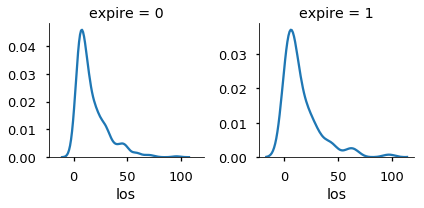

In [24]:
g = sns.FacetGrid(cdiff_patients, col="expire", margin_titles=True, sharey=False)
#bins = np.linspace(0, 50, 10)
g.map(sns.kdeplot, "los") #

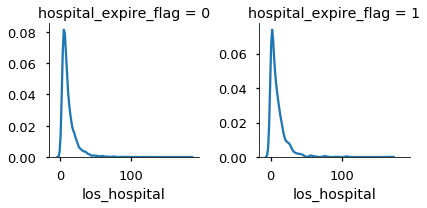

In [22]:
g = sns.FacetGrid(noncd_patients, col="hospital_expire_flag", margin_titles=True, sharey=False)
#bins = np.linspace(0, 50, 10)
g.map(sns.kdeplot, "los_hospital") #, bins=bins, lw=0

In [25]:
def check_id(x):
    if x in cdiff_ids:
        return 1
    else:
        return 0

In [27]:
all_patients['cdiff'] = all_patients.apply(lambda x: check_id(x['hadm_id']), axis=1)

In [70]:
len(all_patients)

7331

In [28]:
all_patients.head()

,hadm_id,subject_id,admittime,admission_type,admission_location,dischtime,los_hospital,age,gender,ethnicity,insurance,marital_status,hospital_expire_flag,hospstay_seq,first_hosp_stay,icd9_code,cdiff
0,145834,3,2101-10-20 19:08:00,EMERGENCY,EMERGENCY ROOM ADMIT,2101-10-31 13:58:00,10.7847,76.5268,M,WHITE,Medicare,MARRIED,0,1,Y,0389,0
1,111970,21,2135-01-30 20:50:00,EMERGENCY,EMERGENCY ROOM ADMIT,2135-02-08 02:08:00,8.2208,87.8263,M,WHITE,Medicare,MARRIED,1,1,Y,0388,1
2,176176,33,2116-12-23 22:30:00,EMERGENCY,EMERGENCY ROOM ADMIT,2116-12-27 12:05:00,3.5660,82.3945,M,UNKNOWN/NOT SPECIFIED,Medicare,MARRIED,0,1,Y,0389,0
3,190797,52,2191-01-10 02:12:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,2191-01-19 16:10:00,9.5819,38.1229,M,WHITE,Private,SINGLE,0,1,Y,7907,0
4,104130,59,2197-11-14 17:07:00,EMERGENCY,EMERGENCY ROOM ADMIT,2197-11-19 16:42:00,4.9826,87.0949,F,WHITE,Medicare,WIDOWED,0,1,Y,5990,0


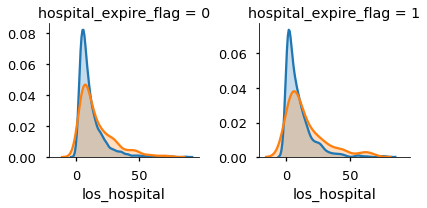

In [32]:
g = sns.FacetGrid(all_patients, col="hospital_expire_flag", hue='cdiff', 
                  margin_titles=True, sharey=False)
#bins = np.linspace(0, 50, 10)
g.map(sns.kdeplot, "los_hospital", shade=True, clip=(0,90)) #, bins=bins, lw=0

In [38]:
noncdiff_mortality = float(len(all_patients[(all_patients.hospital_expire_flag == 1) &
                                      (all_patients.cdiff == 0)]))/len(all_patients[all_patients.cdiff == 0])

In [40]:
cdiff_mortality = float(len(all_patients[(all_patients.hospital_expire_flag == 1) &
                                      (all_patients.cdiff == 1)]))/len(all_patients[all_patients.cdiff == 1])

In [41]:
noncdiff_mortality, cdiff_mortality

(0.19185794716327415, 0.22524752475247525)

In [99]:
sns.set_context('poster', font_scale=1.25)

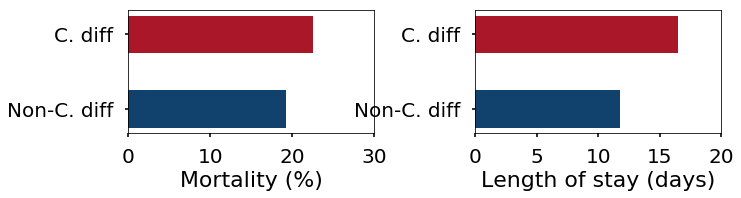

In [104]:
fig, ax  = plt.subplots(1, 2, figsize=(10, 3))  # #114C81, #34A5DA, #18679A
fig.subplots_adjust(wspace=.5)
fig.tight_layout()
ax[0].barh([1, 2], [19.2, 22.5], color=['#11426E','#AA1728'], height=0.5,
       tick_label=['Non-C. diff', 'C. diff'], align='center')
ax[0].set_xlim(0, 30)
ax[0].set_xlabel('Mortality (%)')

ax[1].barh([1, 2], [11.8, 16.5], color=['#11426E','#AA1728'], height=0.5,
       tick_label=['Non-C. diff', 'C. diff'], align='center')
ax[1].set_xlim(0, 20)
ax[1].set_xticks([0, 5, 10, 15, 20])
ax[1].set_xlabel('Length of stay (days)')

plt.savefig('/Users/nwespe/Desktop/cdiff_stats.svg', bbox_inches='tight')

In [49]:
avg_los = all_patients.groupby(['cdiff', 'hospital_expire_flag'], axis=0)['los_hospital'].describe()

In [50]:
avg_los

count       mean        std     min      25%  \
cdiff hospital_expire_flag                                                  
0     0                     5598.0  11.805548  11.115313  0.1535  5.16425   
      1                     1329.0   9.737957  12.709834 -0.3222  1.79580   
1     0                      313.0  16.456613  14.209849  0.8583  6.12080   
      1                       91.0  16.159984  17.686762  0.1951  4.61425   

                                 50%       75%       max  
cdiff hospital_expire_flag                                
0     0                      8.35035  14.63105  181.8924  
      1                      5.91670  12.91040  166.9069  
1     0                     11.65630  21.78820   95.5632  
      1                      9.68260  22.41980   97.2674

In [180]:
all_features, cdiff_data, outcomes = get_sql_dataset.main()

postgresql://nwespe@localhost/mimic
Retrieved data from SQL, have outcomes of length: 39429
Flag value counts: False    38049
True      1380
Name: cdiff, dtype: int64
Merged hospital stays within 90 days, now have outcomes: 35268
Flag value counts: False    34016
True      1252
Name: cdiff, dtype: int64
Removed young patients, now have outcomes: 32092
Flag value counts: False    30840
True      1252
Name: cdiff, dtype: int64
Removed stays shorter than 3 days, now have outcomes:29254
Flag value counts: False    28056
True      1198
Name: cdiff, dtype: int64
Removed admits for cdiff, now have outcomes: 29169
Flag value counts: False    28056
True      1113
Name: cdiff, dtype: int64
Adjusted data values for age, admission time
Removed outliers for height and weight
Log-transformed values for bands, bilirubin, bun, creatinine, glucose, lactate, inr, and wbc
Combined features with outcomes, now have data of length: 28590
Columns are: Index([u'hadm_id', u'aniongap', u'albumin', u'bands', u'b

In [181]:
cdiff_data.head()

,hadm_id,aniongap,albumin,bands,bicarbonate,bilirubin,creatinine,chloride,glucose,hematocrit,...,log_bilirubin,log_bun,log_creatinine,log_glucose,log_lactate,log_inr,log_wbc,outcome,expire,los_hospital
0,164444,15.0,NaN,NaN,23.0,1.0,0.9,108.0,173.0,44.9,...,0.000000,2.890372,-0.105361,5.153292,0.530628,0.095310,2.639057,1,0,16.3674
1,191210,14.0,NaN,NaN,28.0,0.5,0.9,105.0,113.0,41.8,...,-0.693147,2.772589,-0.105361,4.727388,-0.105361,0.095310,1.774952,0,0,4.9896
2,108031,12.0,2.4,NaN,21.0,6.9,1.2,106.0,99.0,38.0,...,1.931521,3.135494,0.182322,4.595120,0.405465,0.262364,2.572612,0,1,8.7938
3,113210,20.0,2.7,11.0,20.0,0.9,1.1,99.0,257.0,35.9,...,-0.105361,3.367296,0.095310,5.549076,0.741937,-0.105361,3.091042,0,1,5.6438
4,115178,16.0,NaN,NaN,24.0,NaN,1.4,108.0,104.0,28.2,...,NaN,3.912023,0.336472,4.644391,NaN,0.875469,2.219203,0,0,11.9076


In [113]:
noncdiff_mortality = float(len(cdiff_data[(cdiff_data.expire == 1) &
                                      (cdiff_data.outcome == 0)]))/len(cdiff_data[cdiff_data.outcome == 0])

In [114]:
cdiff_mortality = float(len(cdiff_data[(cdiff_data.expire == 1) &
                                      (cdiff_data.outcome == 1)]))/len(cdiff_data[cdiff_data.outcome == 1])

In [122]:
noncdiff_mortality, cdiff_mortality

(0.09623567921440263, 0.14246575342465753)

In [123]:
(14.2-9.6)/9.6

0.47916666666666663

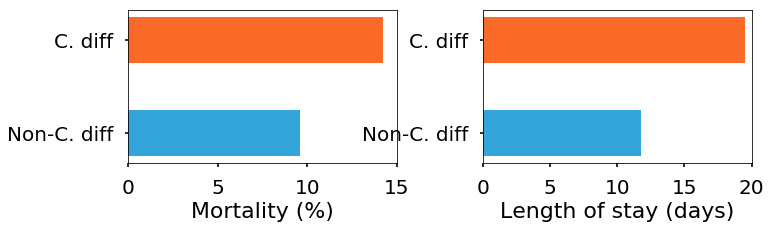

In [164]:
fig, ax  = plt.subplots(1, 2, figsize=(10, 3))  # #114C81, #34A5DA, #18679A
fig.subplots_adjust(wspace=.5)
fig.tight_layout()
ax[0].barh([1, 2], [9.6, 14.2], color=['#34A5DA','#F96928'], height=0.5,
       tick_label=['Non-C. diff', 'C. diff'], align='center')
ax[0].set_xlim(0, 15)
ax[0].set_xlabel('Mortality (%)')

ax[1].barh([1, 2], [11.8, 19.5], color=['#34A5DA','#F96928'], height=0.5,
       tick_label=['Non-C. diff', 'C. diff'], align='center')
ax[1].set_xlim(0, 20)
ax[1].set_xticks([0, 5, 10, 15, 20])
ax[1].set_xlabel('Length of stay (days)')

plt.savefig('/Users/nwespe/Desktop/cdiff_stats.svg', bbox_inches='tight')

In [116]:
avg_los = cdiff_data.groupby(['outcome', 'expire'], axis=0)['los_hospital'].describe()

In [117]:
avg_los

count       mean        std     min       25%       50%  \
outcome expire                                                              
0       0       24849.0  11.813133  10.734280  3.0000  5.795100   8.64310   
        1        2646.0  14.708255  15.009866  3.0007  6.052975   9.99170   
1       0         939.0  19.481517  15.466663  3.0257  8.592700  14.54170   
        1         156.0  19.785528  18.821728  3.2090  8.619250  13.52745   

                      75%       max  
outcome expire                       
0       0       13.926400  294.6604  
        1       17.549500  206.4257  
1       0       25.707600  112.1792  
        1       23.160075  145.8576

In [130]:
(19.8-11.8)/11.8

0.6779661016949152

In [179]:
cdiff_data.columns

Index([u'hadm_id', u'aniongap', u'albumin', u'bands', u'bicarbonate',
       u'bilirubin', u'creatinine', u'chloride', u'glucose', u'hematocrit',
       u'hemoglobin', u'lactate', u'platelet', u'potassium', u'ptt', u'inr',
       u'pt', u'sodium', u'bun', u'wbc', u'heartrate_min', u'heartrate_max',
       u'heartrate_mean', u'sysbp_min', u'sysbp_max', u'sysbp_mean',
       u'diasbp_min', u'diasbp_max', u'diasbp_mean', u'meanbp_min',
       u'meanbp_max', u'meanbp_mean', u'resprate_min', u'resprate_max',
       u'resprate_mean', u'tempc_min', u'tempc_max', u'tempc_mean',
       u'spo2_min', u'spo2_max', u'spo2_mean', u'glucose_mean', u'weight',
       u'height', u'age', u'gender', u'bmi', u'time_of_admission',
       u'log_bands', u'log_bilirubin', u'log_bun', u'log_creatinine',
       u'log_glucose', u'log_lactate', u'log_inr', u'log_wbc', u'outcome',
       u'expire', u'los_hospital'],
      dtype='object')

In [149]:
import itertools

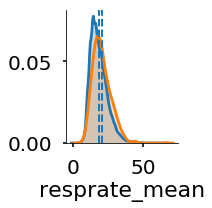

In [177]:
means = cdiff_data.groupby(['outcome'], axis=0)['admittime'].mean()
g = sns.FacetGrid(cdiff_data, hue='outcome', margin_titles=True, sharey=False)
g.map(sns.kdeplot, 'admittime', shade=True) #, bins=bins, lw=0, clip=(0,90)
axes = plt.gca()
#axes.set_ylim([0, 0.03])
for m in means:
    plt.axvline(m, linestyle='dashed', linewidth=2)
plt.savefig('/Users/nwespe/Desktop/Week4Graphics/Plots/admittime.svg', bbox_inches='tight')

//anaconda/envs/my_insight_env/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


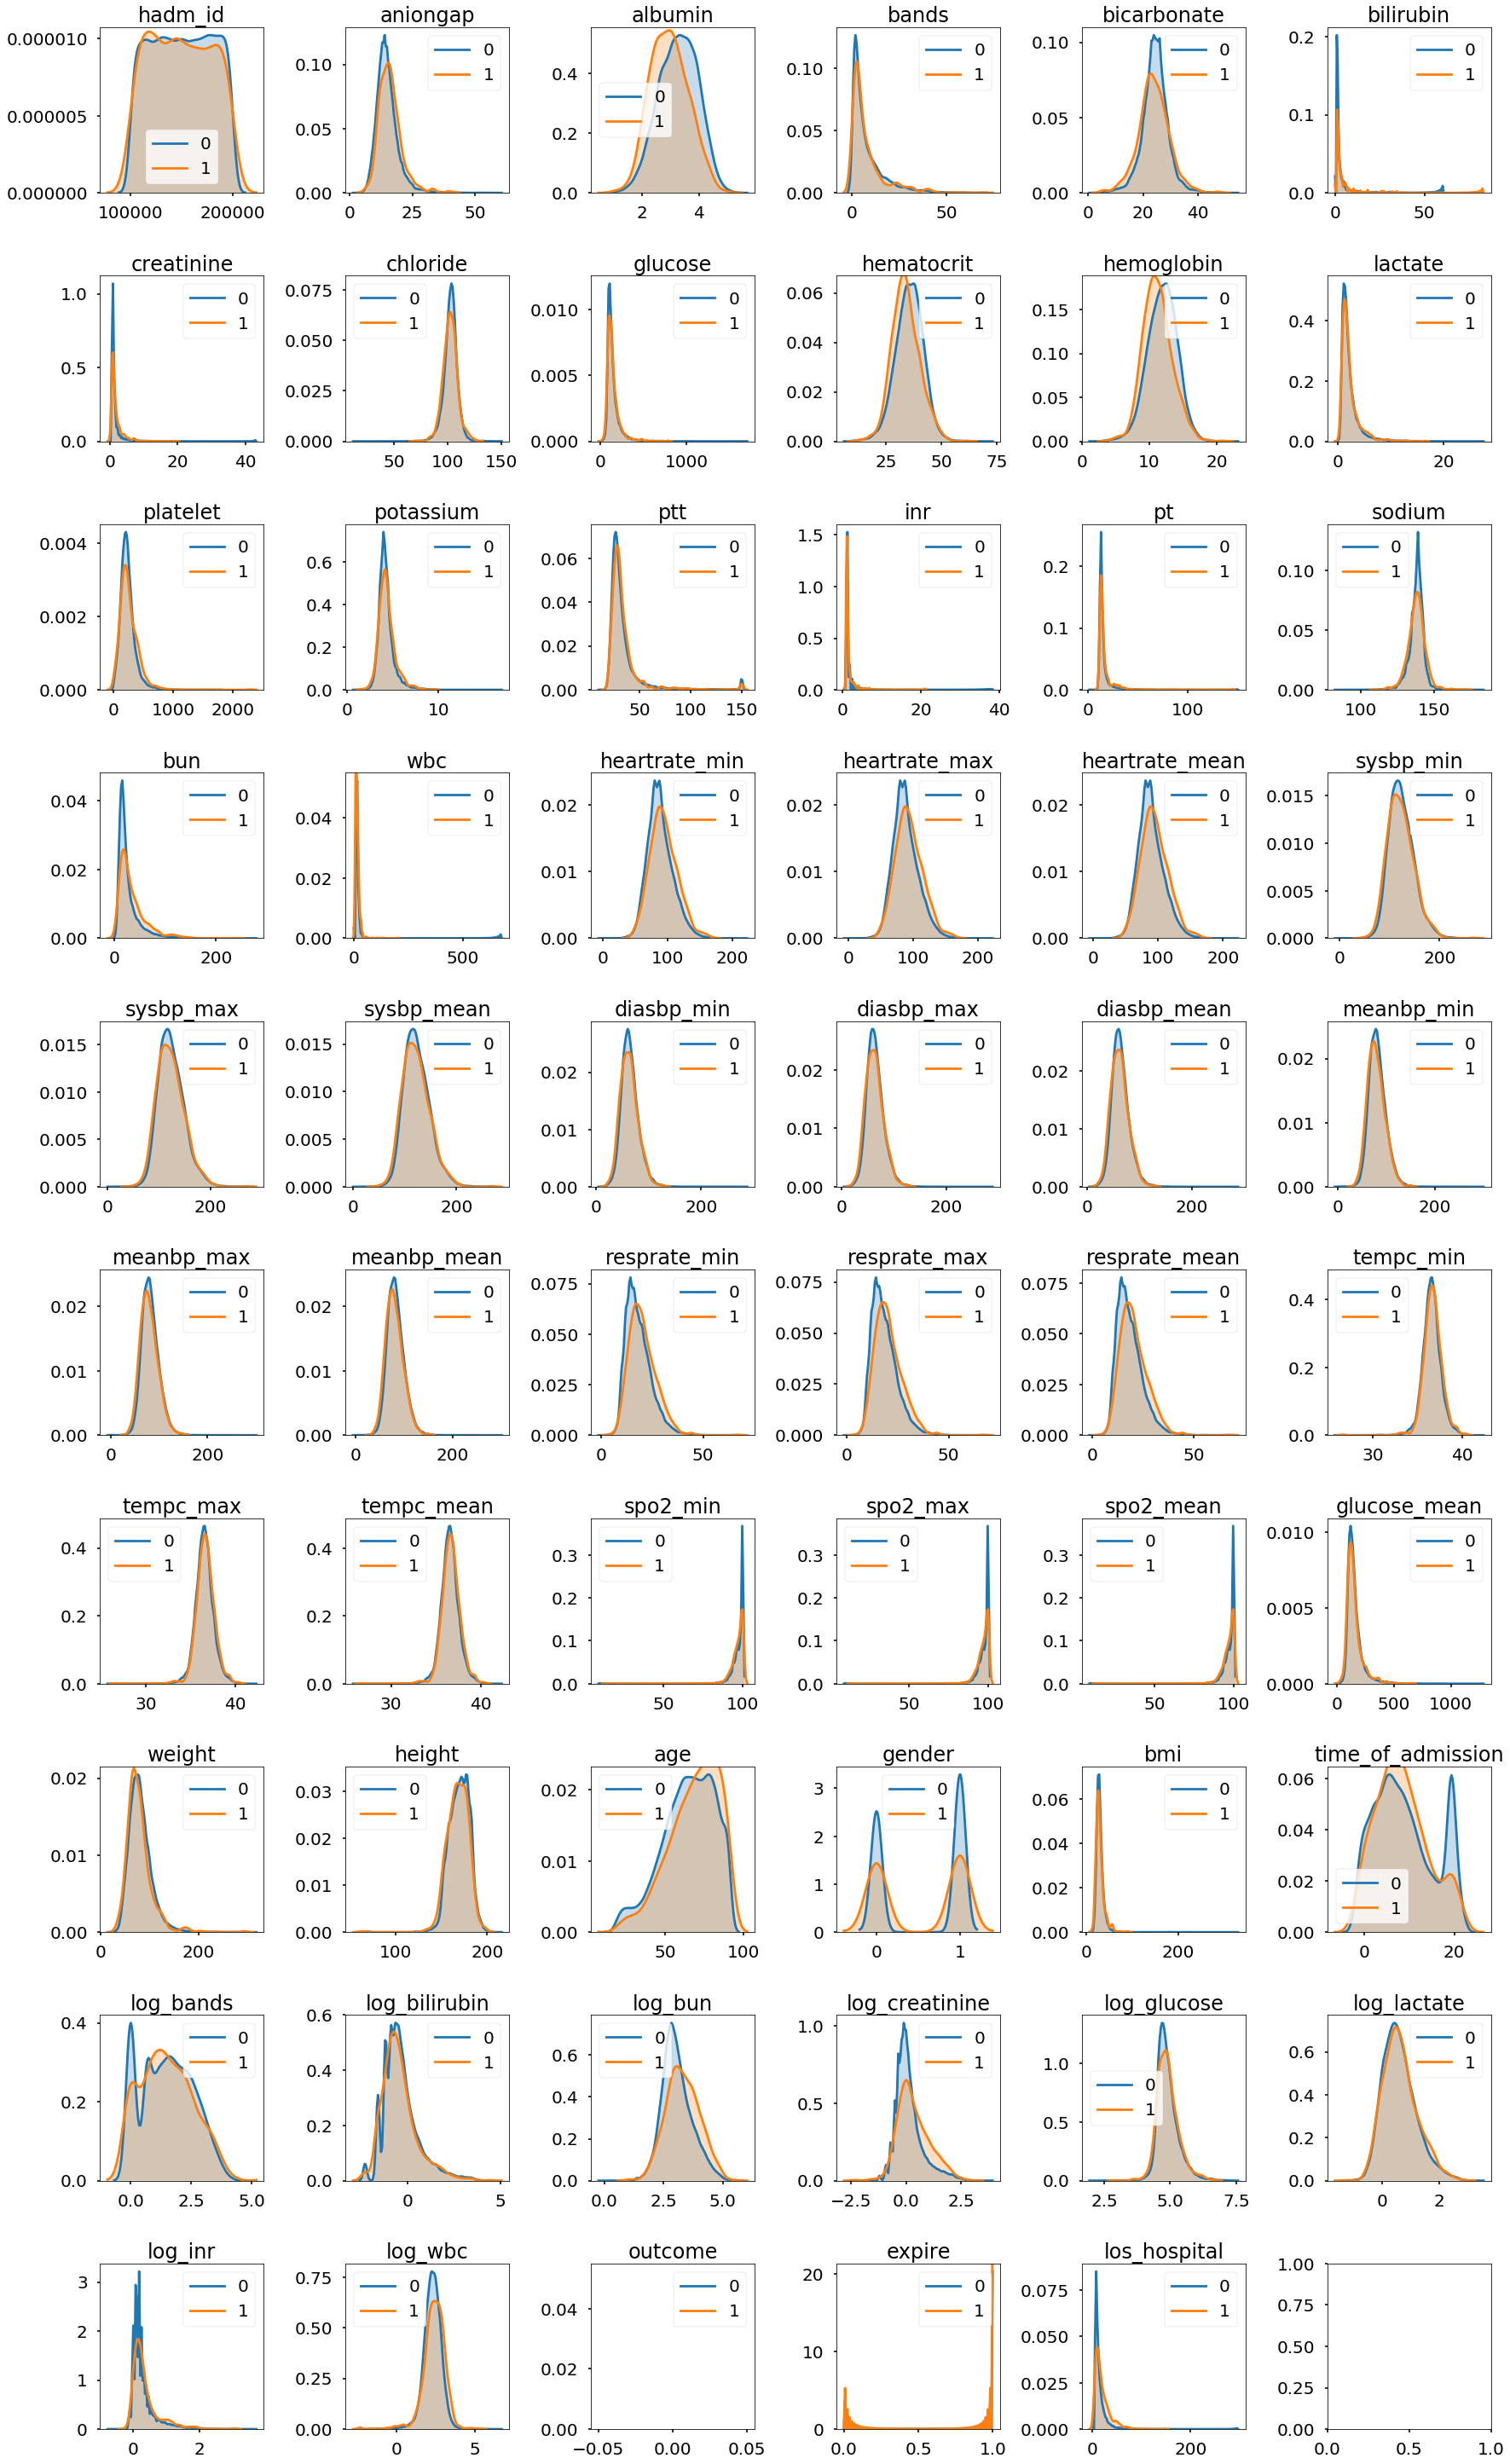

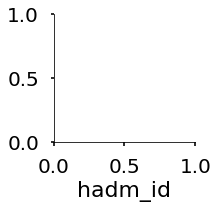

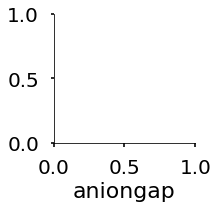

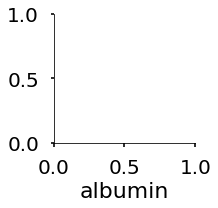

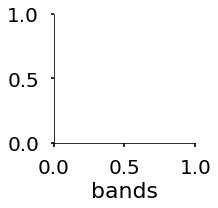

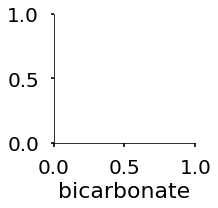

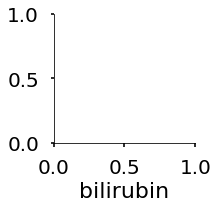

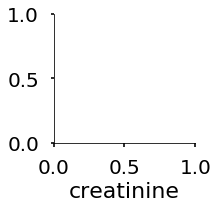

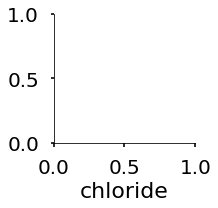

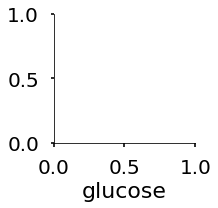

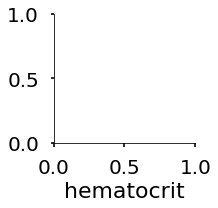

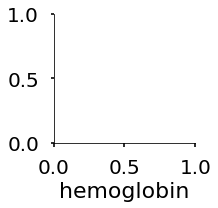

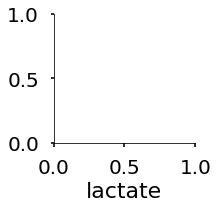

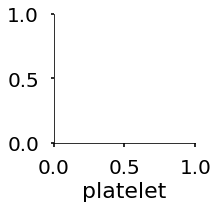

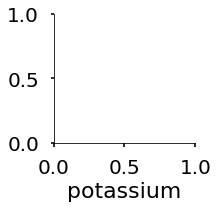

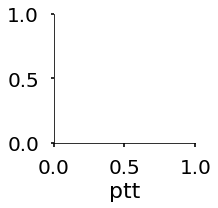

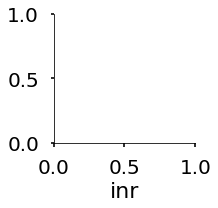

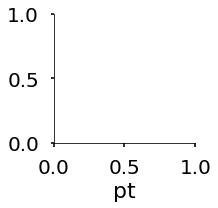

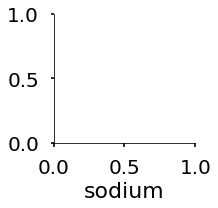

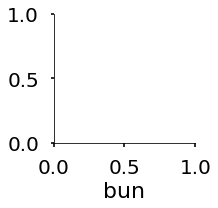

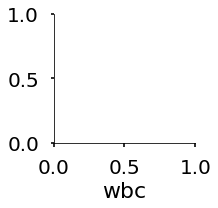

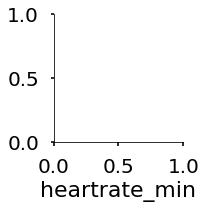

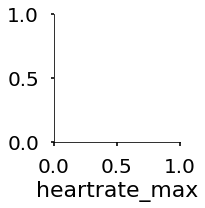

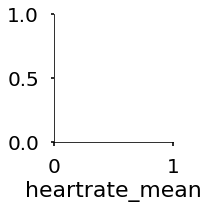

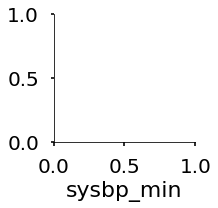

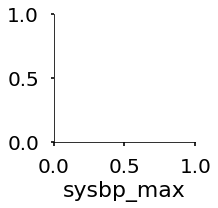

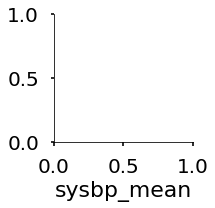

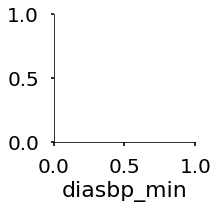

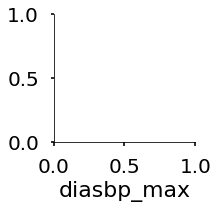

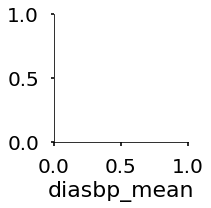

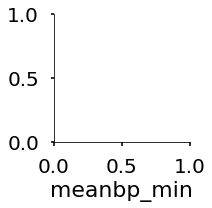

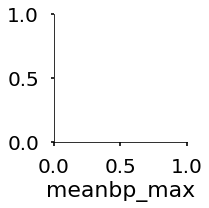

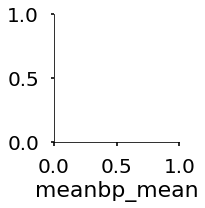

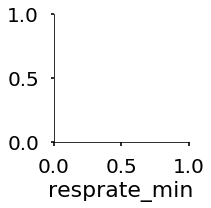

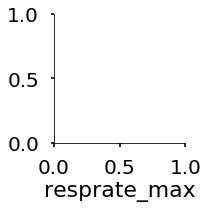

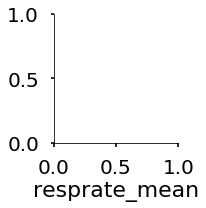

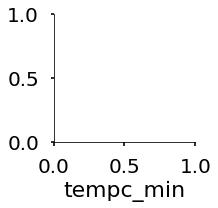

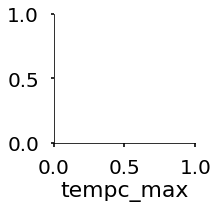

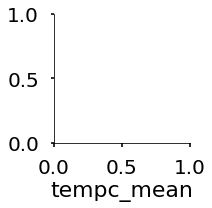

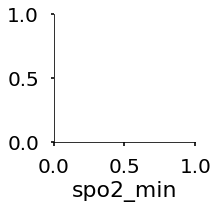

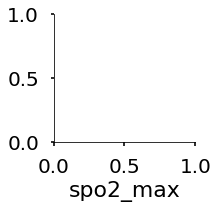

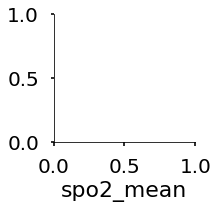

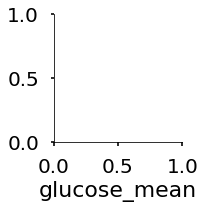

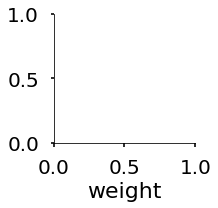

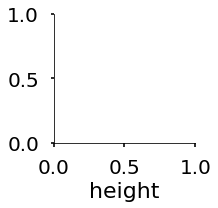

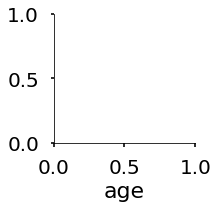

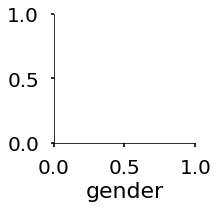

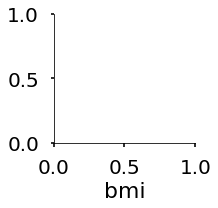

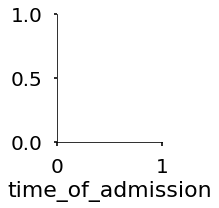

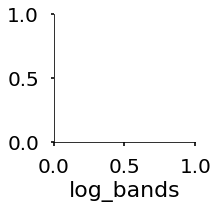

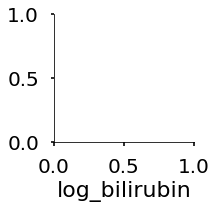

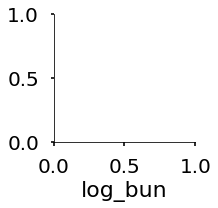

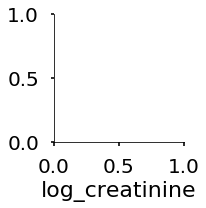

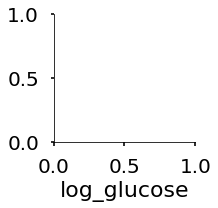

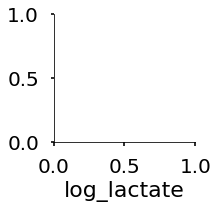

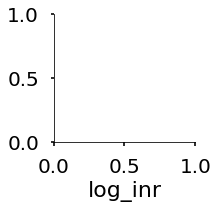

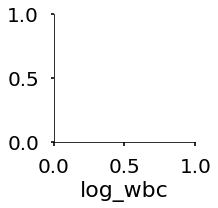

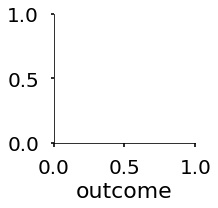

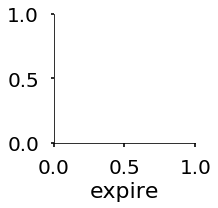

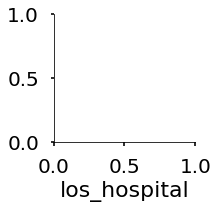

In [148]:
ncols = 6
nrows = len(cdiff_data.columns)//6 + 1
axis_ids = list(itertools.product(xrange(nrows), xrange(ncols)))


#bins = np.linspace(0, 50, 10)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
fig.tight_layout()
fig.subplots_adjust(wspace=0.5, hspace=0.5)
for ix, c in enumerate(cdiff_data.columns):
    i, j = axis_ids[ix]
    g = sns.FacetGrid(cdiff_data, hue='outcome', margin_titles=True, sharey=False)
    g.map(sns.kdeplot, c, shade=True, ax=axes[i, j]) #, bins=bins, lw=0, clip=(0,90)
    axes[i, j].set_title(c)